# Hydrogen Energy Comparative Analysis across African Countries

This notebook supports a comparison of hydrogen‐sector metrics for multiple African countries. Each country’s results come from a solved PyPSA network (single‐country model) produced by the `solve_sector_networks` rule. Extracted metrics are both **static** and **time-series** in order to highlight differences in capacity, flows, performance, economics, cost, and export dynamics.


* **Input Networks**

  * Located in `../networks/solved_h2/` (relative to `h2g-a/notebooks/`)
  * One `.nc` file per country, solved by `solve_sector_networks`
  * Country code = last two letters of filename → mapped to full name via `pycountry`

* **Workflow Overview**

  1. **Load Networks**

     * Discover `.nc` files
     * Map 2-letter codes → country names
     * Load into `pypsa.Network` objects
  2. **Extract Metrics**

     * **Core metrics**:

       * Installed & Optimal Capacity
       * Supply, Withdrawal, Balance, Transmission
       * Capacity Factor & Curtailment
       * CapEx, OpEx, Revenue, Market Value
     * **Cost metrics**:

       * LCOH (€/MWh)
       * Total cost per TWh (M€/TWh)
  3. **Build Combined Dictionary**

     * Merge core + cost metrics per country
  4. **Static Comparisons**

     * Group factors into:

       * Capacity (GW)
       * Flows (GWh)
       * Performance (%)
       * Economics (€)
       * Cost Metrics
     * Plot each group as a grouped‐bar chart
  5. **Time‐Series Comparisons**

     * Hourly H₂ export price (€/MWh)
     * Hourly export quantity (MWh)
     * Hourly export revenue (€)

* **How to Interpret**

  * **Capacity plots** show "Installed Capacity" and "Optimal Capacity"
  * **Flows** shows "Supply", "Withdrawal", "Energy Balance", and "Transmission"
  * **Performance** show "Capacity Factor" and "Curtailment"
  * **Economic metrics** show "Capital Expenditure", "Operational Expenditure", "Revenue", and "Market Value"
  * **Cost metrics** benchmark "LCOH (€/MWh)" and "Cost (M€/TWh)"
  * **Time‐series** benchmark temporal patterns in export markets


### Packages import

In [99]:
from pathlib import Path
import re
import pypsa
import pycountry
import warnings
import matplotlib.pyplot as plt

### Networks loading


In [100]:
nc_dir = Path.cwd().parents[0] / "networks" / "solved_h2"
nc_paths = list(nc_dir.glob("*.nc"))

def code_to_country(code):
    c = pycountry.countries.get(alpha_2=code.upper())
    return c.name if c else code.upper()

# load each network under its full country name
networks = {}
for p in nc_paths:
    m = re.search(r'_(\w\w)\.nc$', p.name)
    code = m.group(1) if m else p.stem
    name = code_to_country(code)
    networks[name] = pypsa.Network(str(p))

warnings.filterwarnings("default")

### Data Extraction

In [101]:
def get_core_metrics(n):
    stats = n.statistics().loc["Link", "H2 Electrolysis"]
    return {
        "Installed Capacity":      n.statistics.installed_capacity('Link').loc["H2 Electrolysis"],
        "Optimal Capacity":        n.statistics.optimal_capacity('Link').loc["H2 Electrolysis"],
        "Supply":                  stats["Supply"],
        "Withdrawal":              stats["Withdrawal"],
        "Energy Balance":          stats["Energy Balance"],
        "Transmission":            stats["Transmission"],
        "Capacity Factor":         stats["Capacity Factor"],
        "Curtailment":             stats["Curtailment"],
        "Capital Expenditure":     stats["Capital Expenditure"],
        "Operational Expenditure": stats["Operational Expenditure"],
        "Revenue":                 stats["Revenue"],
        "Market Value":            stats["Market Value"],
    }

def get_cost_metrics(n):
    stats = n.statistics().loc["Link", "H2 Electrolysis"]
    capex_M = stats["Capital Expenditure"] / 1e6
    opex_M  = stats["Operational Expenditure"] / 1e6
    supply_TWh = stats["Supply"].sum() / 1e6

    # electricity cost in M€
    ac = n.buses[n.buses.carrier=="AC"].index
    price = n.buses_t.marginal_price[ac]
    demand = n.links_t.p1[n.links[n.links.carrier=="H2 Electrolysis"].index]
    demand.columns = price.columns
    e_cost_M = ((price * demand).sum().sum() * -1 * n.snapshot_weightings.generators[0]) / 1e6

    lcoh = ((capex_M + opex_M + e_cost_M) / (stats["Supply"]/1e6)).round(2)
    cost_per_TWh = ((capex_M + opex_M) / supply_TWh).round(2)

    return {
        "LCOH (€/MWh)":  lcoh,
        "Cost (M€/TWh)": cost_per_TWh,
    }

def get_h2_export_prices(n):
    buses = n.buses[n.buses.index.str.contains("H2", False)].index
    return n.buses_t.marginal_price[buses]["H2 export bus"]

def get_h2_export_quantity(n):
    links = n.links[n.links.carrier=="H2"].index
    qty = n.links_t.p1[links]
    cols = [c for c in qty if "H2 export" in c]
    total = qty[cols].sum(axis=1)
    total.name = "H2 export"
    return total

def get_h2_export_revenue(n):
    price = get_h2_export_prices(n)
    qty   = get_h2_export_quantity(n).reindex(price.index).fillna(0)
    return (price * qty).rename("Revenue")


### Metrics Building

In [ ]:
all_metrics = {}
for country, net in networks.items():
    core = get_core_metrics(net)
    cost = get_cost_metrics(net)
    all_metrics[country] = {**core, **cost}

### Group Related Metrics

In [103]:
groups = {
    "Capacity (MW)": ["Installed Capacity", "Optimal Capacity"],
    "Flows (MWh)": ["Supply", "Withdrawal", "Energy Balance", "Transmission"],
    "Performance (%)": ["Capacity Factor", "Curtailment"],
    "Economics (€)": ["Capital Expenditure", "Operational Expenditure", "Revenue", "Market Value"],
    "Cost Metrics": ["LCOH (€/MWh)", "Cost (M€/TWh)"],
}

### Helper function

In [104]:
def plot_metrics_group(metrics, items, title):
    countries = sorted(metrics)
    n, m = len(countries), len(items)
    idx = range(n)
    w = 0.8 / m

    plt.figure(figsize=(max(6, n*0.5), 4))
    for i, key in enumerate(items):
        vals = [metrics[c][key] for c in countries]
        plt.bar([x + i*w for x in idx], vals, w, label=key)

    plt.xticks([x + w*(m-1)/2 for x in idx], countries)
    plt.title(title)
    plt.ylabel(title)
    plt.xlabel("Country")
    plt.legend(ncol=m, fontsize="small", loc="upper center", bbox_to_anchor=(0.5,-0.15))
    plt.tight_layout()
    plt.show()

### Bar Charts

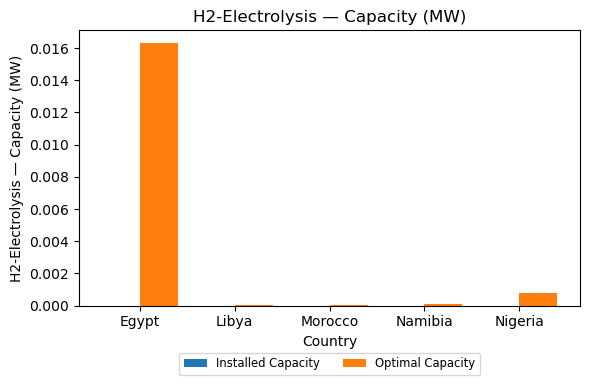

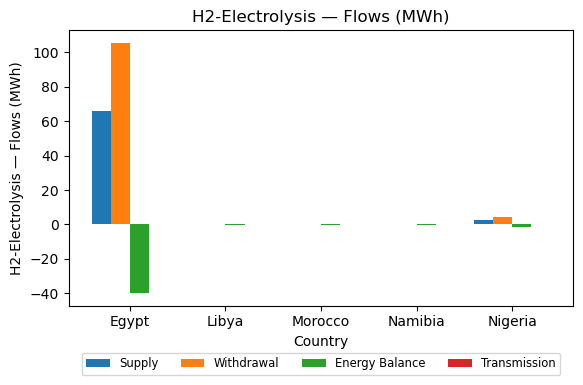

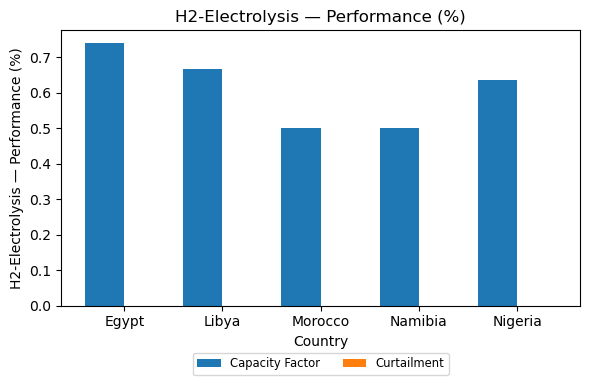

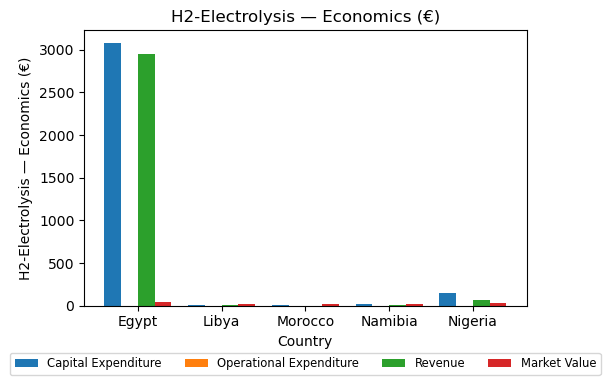

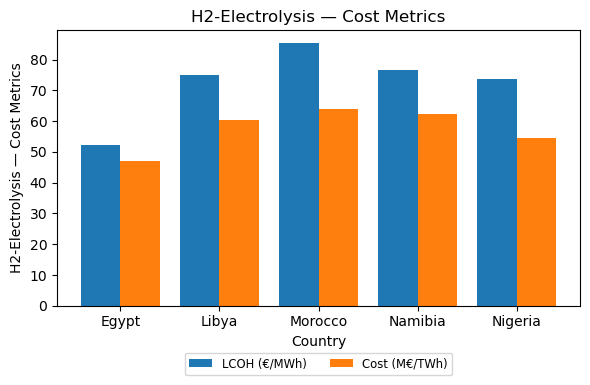

In [105]:
for title, items in groups.items():
    plot_metrics_group(all_metrics, items, f"H2-Electrolysis — {title}")

### Time-series Plots

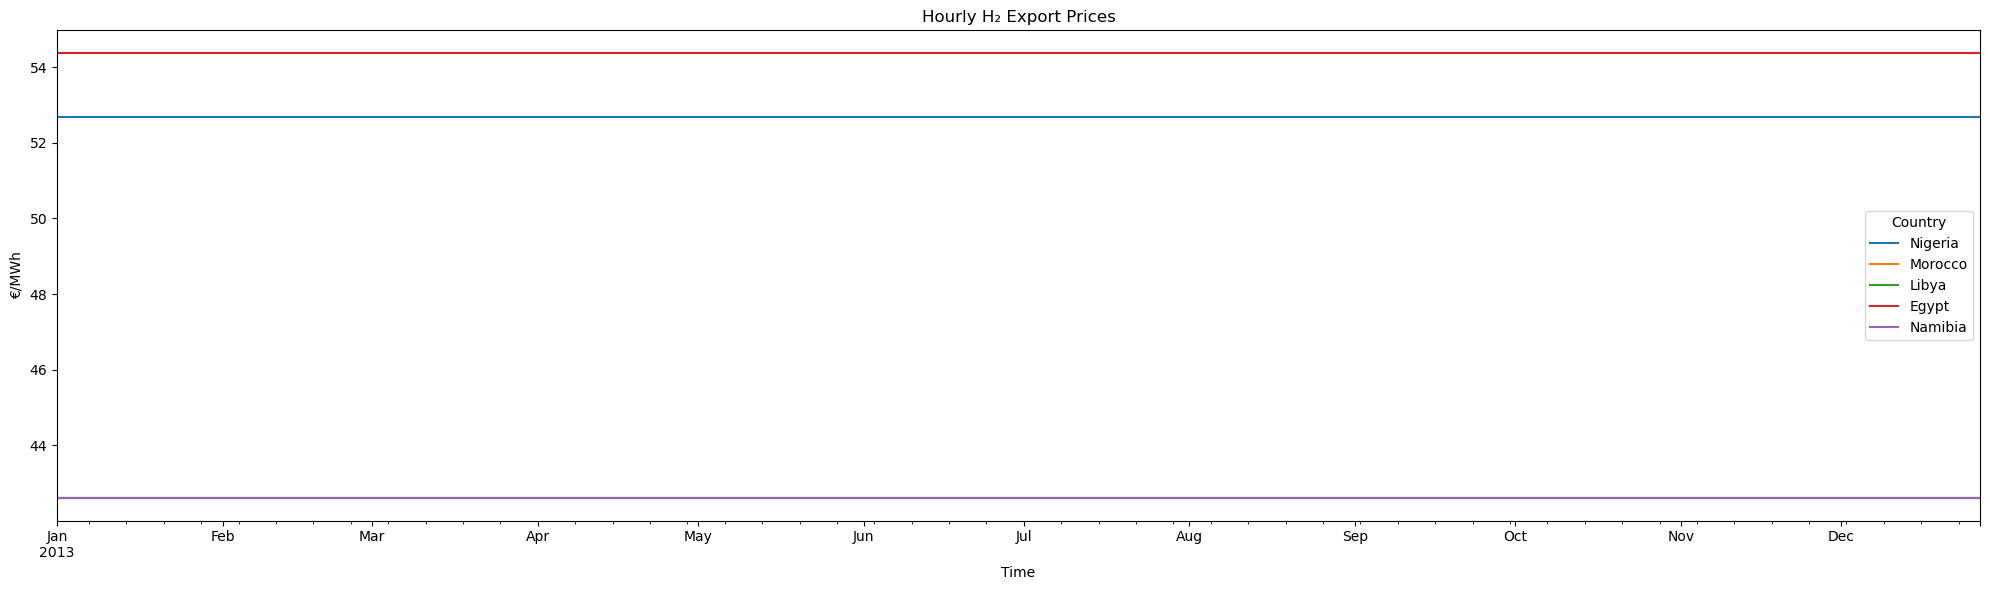

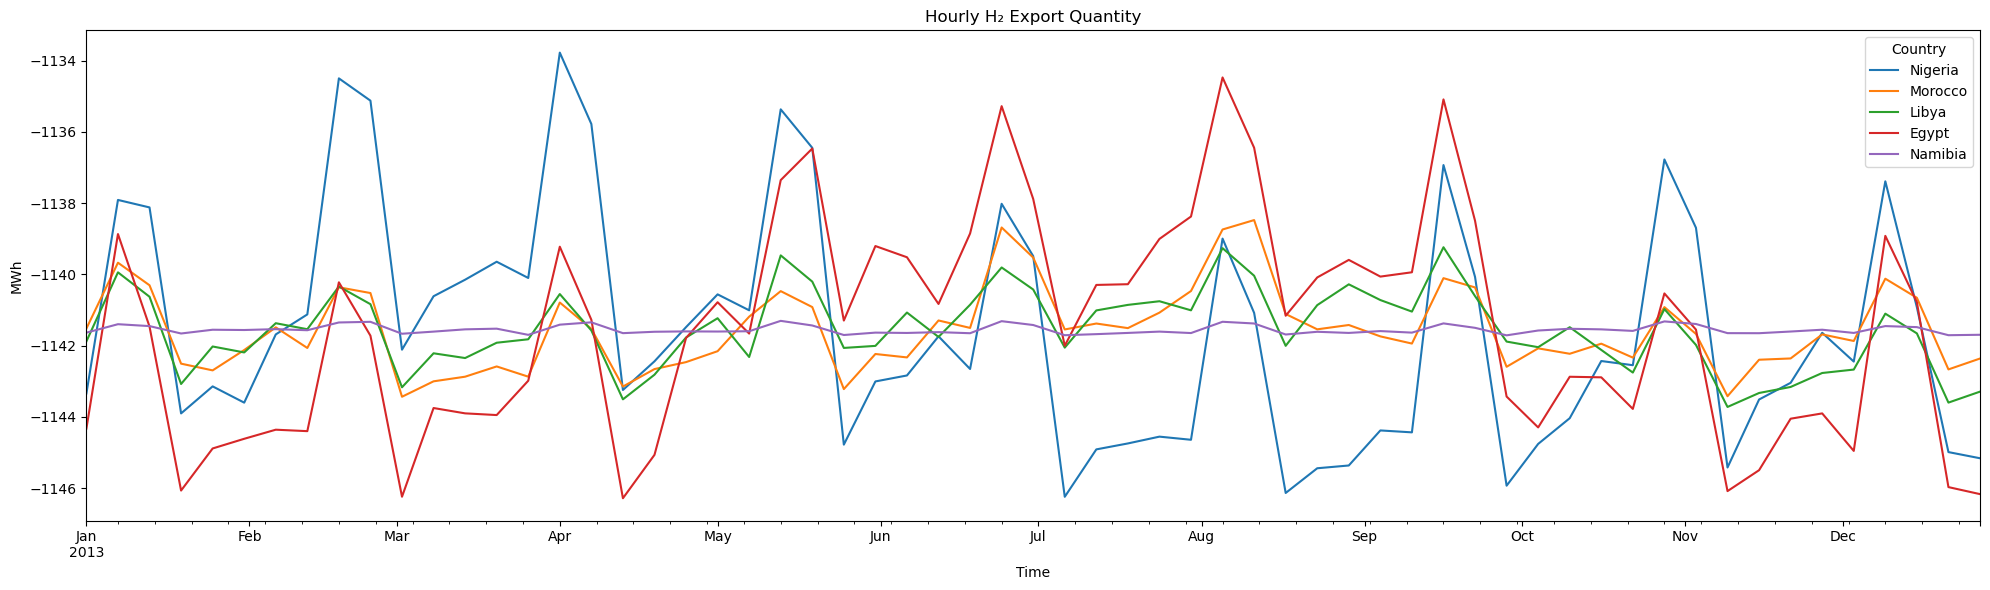

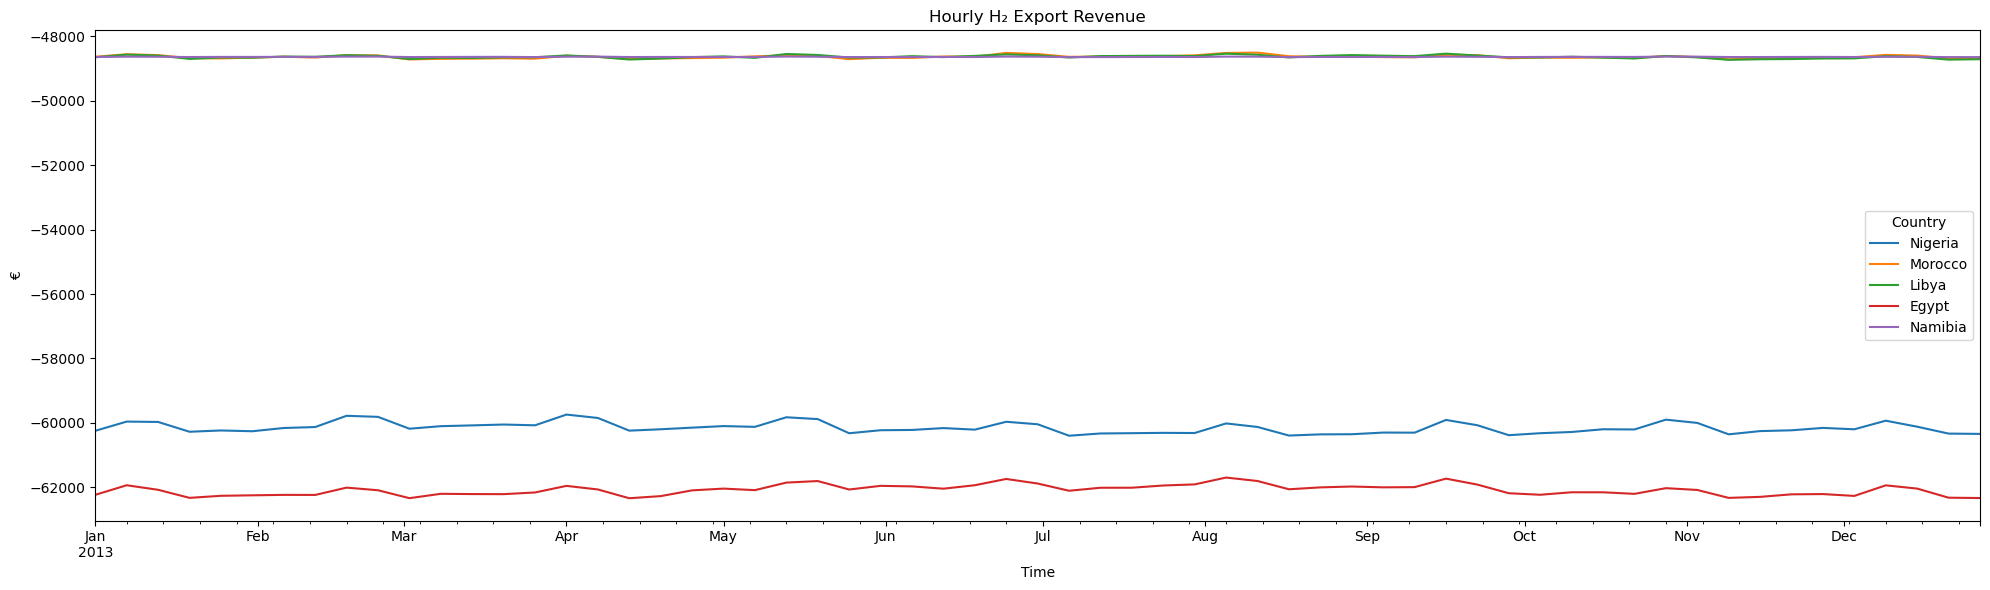

In [106]:
plt.figure(figsize=(20,6))

for name, net in networks.items():
    get_h2_export_prices(net).plot(label=name)

plt.title("Hourly H₂ Export Prices")
plt.xlabel("Time"); plt.ylabel("€/MWh")
plt.legend(title="Country"); plt.tight_layout(); plt.show()
plt.figure(figsize=(20,6))

for name, net in networks.items():
    get_h2_export_quantity(net).plot(label=name)

plt.title("Hourly H₂ Export Quantity")
plt.xlabel("Time"); plt.ylabel("MWh")
plt.legend(title="Country"); plt.tight_layout(); plt.show()
plt.figure(figsize=(20,6))

for name, net in networks.items():
    get_h2_export_revenue(net).plot(label=name)
    
plt.title("Hourly H₂ Export Revenue")
plt.xlabel("Time"); plt.ylabel("€")
plt.legend(title="Country"); plt.tight_layout(); plt.show()
